## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

from collections import OrderedDict 
from sklearn import metrics
from torch.optim import Adam

sys.path.append(os.path.abspath(''))

import utils.more_torch_functions as mtf
import datasets

from utils.custom_loss import AsymBCELoss
from utils.custom_activations import StepActivation
from utils.modules import Parallel, MaxLayer
from utils.misc import train_model, cov_score

# torch.autograd.set_detect_anomaly(True)

## Load data

In [2]:
np_x, np_y = datasets.DiabetesDataset.get_dataset(balancing=True, discretizing=False, hot_encoding=True)
x_data, y_data = torch.Tensor(np_x), torch.Tensor(np_y)
input_size = x_data.size(1)
print(x_data.size())

torch.Size([536, 8])


## Hooks

In [3]:
intermediate_outputs = {}
def get_intermediate_outputs(name):
    def hook(model, input, output):
        if model.training:
            intermediate_outputs.setdefault(name, dict())["train"] = output
        else:
            intermediate_outputs.setdefault(name, dict())["valid"] = output
    return hook

def true_label_for_backward(train, valid):
    def hook(model, input):
        if model.training:
            model.true_labels = train
        else:
            model.true_labels = valid
    return hook

# créer hook fonction de perte pour meilleur backward ? (comparer individuellement les sorties des réseaux ???)

## Networks

### Network parts

In [4]:
class ApproxNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        hl1 = 10

        self.nn = nn.Sequential(OrderedDict([
            ('l1', nn.Linear(input_size,hl1)),
            ('a1', StepActivation()),
            ('l2', nn.Linear(hl1,1)),
            ('a2', StepActivation())
        ]))        

    def forward(self, x):
        x = self.nn(x)

        return x

class BigNet(nn.Module):
    def __init__(self):
        super().__init__()

        hl1 = 50
        hl2 = 25

        self. nn = nn.Sequential(OrderedDict([
            ('l1', nn.Linear(input_size,hl1)),
            ('a1', nn.Sigmoid()),
            ('l2', nn.Linear(hl1,hl2)),
            ('a2', nn.Sigmoid()),
            ('l3', nn.Linear(hl2,1)),
            ('a3', StepActivation()),
        ]))
    
    def forward(self, x):
        x = self.nn(x)

        return x

### Network definition

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(OrderedDict([
            ('nets', Parallel(OrderedDict([
                ('apx1', ApproxNet()),
                ('apx2', ApproxNet()),
                ('apx3', ApproxNet()),
            ]))),
            ('or_', MaxLayer()),
        ]))

    def forward(self, input):
        return self.net(input)
    
class BlankNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.net = nn.Sequential(OrderedDict([
            ('nets', Parallel(OrderedDict([
            ]))),
            ('or_', MaxLayer()),
        ]))

    def forward(self, input):
        return self.net(input)

## Network evaluation

In [6]:
def eval_model(x_train, y_train, x_valid, y_valid, model, criterion, optimizer):
    train_model(x_train, y_train, model, criterion, optimizer, 500)
    model.eval()
    pred_train = model(x_train).detach()
    pred_valid = model(x_valid).detach()

    f1_train = metrics.f1_score(y_train, pred_train)
    cov_train = cov_score(y_train, pred_train)
    f1_valid = metrics.f1_score(y_valid, pred_valid)
    cov_valid = cov_score(y_valid, pred_valid)

    return f1_train, cov_train, f1_valid, cov_valid

def print_eval(x_train, y_train, x_valid, y_valid, model, criterion, optimizer):
    f1_train, cov_train, f1_valid, cov_valid = eval_model(x_train, y_train, x_valid, y_valid, model, criterion, optimizer)
    print(
        f"{'':<15}{'Train':^15}{'Valid':^15}",
        f"{'F1 score':<15}{f1_train:^15.3f}{f1_valid:^15.3f}",
        f"{'Coverage [0]':<15}{cov_train[0]:^15.3f}{cov_valid[0]:^15.3f}",
        f"{'         [1]':<15}{cov_train[1]:^15.3f}{cov_valid[1]:^15.3f}",
        sep="\n"
    )

In [7]:
model = Net()
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)

model.net.nets.register_forward_hook(get_intermediate_outputs("parallel_out"))
train_index, valid_index = torch.utils.data.random_split(range(x_data.size(0)), [0.9, 0.1])

x_train, y_train = x_data[train_index], y_data[train_index]
x_valid, y_valid = x_data[valid_index], y_data[valid_index]

print_eval(x_train, y_train, x_valid, y_valid, model, criterion, optimizer)

                    Train          Valid     
F1 score            0.855          0.781     
Coverage [0]        0.798          0.560     
         [1]        0.900          0.893     


In [8]:
for param in model.parameters():
    param.requires_grad = False

model.net.nets.add_module("nn", BigNet())
optimizer = Adam(model.net.nets.nn.parameters(), lr=1e-2, weight_decay=1e-6)

print_eval(x_train, y_train, x_valid, y_valid, model, criterion, optimizer)

                    Train          Valid     
F1 score            0.862          0.781     
Coverage [0]        0.798          0.560     
         [1]        0.912          0.893     


### Comments

very small increase in both metrics (sometimes even decreases in performances)

In [9]:
model = BlankNet()
criterion = AsymBCELoss(5)

n_apx = 10

apx_metrics = {f"{set}/{metric}": list() for metric in ("f1", "cov0", "cov1") for set in ("train", "valid")}
for apxi in (f"apx{i}" for i in range(1, n_apx+1)):
    for param in model.parameters():
        param.requires_grad = False
    model.net.nets.add_module(apxi, ApproxNet())
    optimizer = Adam(getattr(model.net.nets, apxi).parameters(), lr=1e-2, weight_decay=1e-6)

    f1t, covt, f1v , covv = eval_model(x_train, y_train, x_valid, y_valid, model, criterion, optimizer)
    apx_metrics["train/f1"].append(f1t)
    apx_metrics["valid/f1"].append(f1v)
    apx_metrics["train/cov0"].append(covt[0])
    apx_metrics["valid/cov0"].append(covv[0])
    apx_metrics["train/cov1"].append(covt[1])
    apx_metrics["valid/cov1"].append(covv[1])

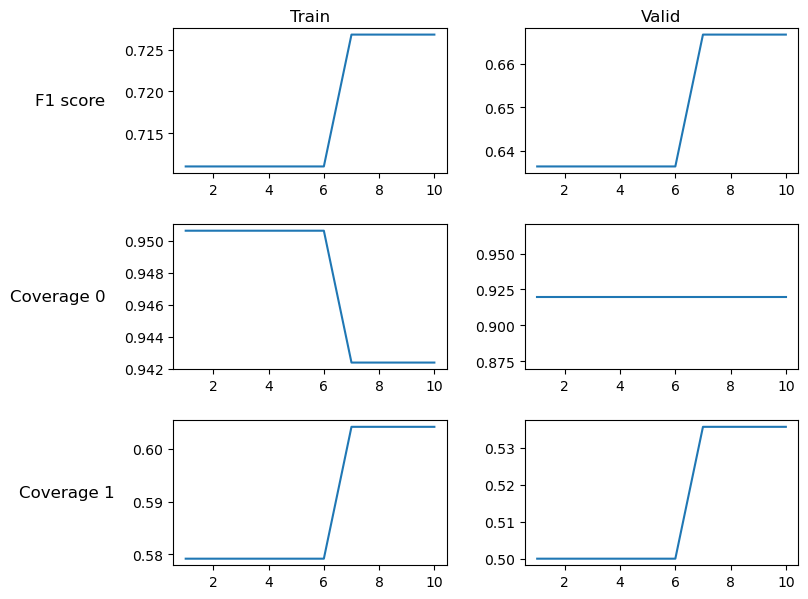

In [10]:
fig, axs = plt.subplots(3,2)

x_axis = list(range(1, n_apx+1))
for ax, metric in zip(axs.flat, apx_metrics.values()):
    ax.plot(x_axis, metric)
    # ax.set_ylim(0,1)

cols = ["Train", "Valid"]
rows = ["F1 score", "Coverage 0", "Coverage 1"]

pad = 5
for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

fig.tight_layout()
fig.subplots_adjust(left=0, top=1.2)

### Paramètres

- nombre d'epochs
- nombre d'approx
- ré-entrainement à chaque approx ajoutée (oui/non/pondération???)
- paramètres optimizer/criterion

### But

- trouver le bon équilibre entre une bonne couverture de 1 et la couverture de 0 (mauvaise classification du label)